In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import joblib
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

: 

In [3]:
# model_evaluator


# === Load Models ===
print("Loading models...")

try:
    ab = joblib.load('/home/josiamosses/Desktop/Brain-Tumor-Detection-ML-app/models/adaboost.pkl')
    print("AdaBoost loaded.")
    cb = joblib.load('/home/josiamosses/Desktop/Brain-Tumor-Detection-ML-app/models/catboost.pkl')
    print("CatBoost loaded.")
    cnn = load_model('/home/josiamosses/Desktop/Brain-Tumor-Detection-ML-app/models/cnn_model.h5')
    print("CNN loaded.")
    vgg = load_model('/home/josiamosses/Desktop/Brain-Tumor-Detection-ML-app/models/transfer_learning_model.h5')
    print("VGG16 Transfer Learning loaded.")
    ensemble = joblib.load('/home/josiamosses/Desktop/Brain-Tumor-Detection-ML-app/models/voting_classifier.pkl')
    print("VotingClassifier loaded.")
except Exception as e:
    print("Error loading models:", e)

# === Class Labels ===
label_map = {'no_tumor': 0, 'glioma_tumor': 1, 'meningioma_tumor': 1, 'pituitary_tumor': 1}

# === Helper Preprocessing Functions ===
def preprocess_gray(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128)) / 255.0
    return img.reshape(1, -1), img.reshape(1, 128, 128, 1)

def preprocess_rgb(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (128, 128)) / 255.0
    return img.reshape(1, 128, 128, 3)

# === Loop through images and make predictions ===
results = []

print("Beginning evaluation...")

for cls in label_map:
    folder = f'data/test_evaluation/{cls}'
    if not os.path.exists(folder):
        print(f"Skipping {cls} – folder not found.")
        continue

    for fname in os.listdir(folder):
        if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        path = os.path.join(folder, fname)
        true_label = label_map[cls]

        flat_img, cnn_img = preprocess_gray(path)
        vgg_img = preprocess_rgb(path)

        preds = {}
        confs = {}

        try:
            preds['Ada'] = ab.predict(flat_img)[0]
            confs['Ada'] = ab.predict_proba(flat_img)[0][int(preds['Ada'])]

            preds['Cat'] = cb.predict(flat_img)[0]
            confs['Cat'] = cb.predict_proba(flat_img)[0][int(preds['Cat'])]

            cnn_out = cnn.predict(cnn_img)[0][0]
            preds['CNN'] = int(cnn_out > 0.5)
            confs['CNN'] = cnn_out if preds['CNN'] == 1 else 1 - cnn_out

            vgg_out = vgg.predict(vgg_img)[0][0]
            preds['VGG'] = int(vgg_out > 0.5)
            confs['VGG'] = vgg_out if preds['VGG'] == 1 else 1 - vgg_out

            preds['Ens'] = ensemble.predict(flat_img)[0]
            confs['Ens'] = ensemble.predict_proba(flat_img)[0][int(preds['Ens'])]

            results.append({
                'image': path,
                'true': true_label,
                'adaboost_pred': preds['Ada'],
                'adaboost_conf': round(confs['Ada'] * 100, 2),
                'catboost_pred': preds['Cat'],
                'catboost_conf': round(confs['Cat'] * 100, 2),
                'cnn_pred': preds['CNN'],
                'cnn_conf': round(confs['CNN'] * 100, 2),
                'vgg_pred': preds['VGG'],
                'vgg_conf': round(confs['VGG'] * 100, 2),
                'ensemble_pred': preds['Ens'],
                'ensemble_conf': round(confs['Ens'] * 100, 2),
            })
        except Exception as e:
            print(f"Error processing {path}: {e}")

# === Save to CSV ===
output_file = 'data/test_evaluation/test_evaluation.csv'
pd.DataFrame(results).to_csv(output_file, index=False)
print(f"\n✅ Evaluation complete. Results saved to: {output_file}")


Loading models...
AdaBoost loaded.
CatBoost loaded.
CNN loaded.
VGG16 Transfer Learning loaded.
VotingClassifier loaded.
Beginning evaluation...
1/1 [==============================] - 0s 79ms/step

✅ Evaluation complete. Results saved to: data/test_evaluation/test_evaluation.csv


In [5]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

df = pd.read_csv('data/test_evaluation/test_evaluation.csv')
print("Total Images Evaluated:", len(df))

models = ['adaboost', 'catboost', 'cnn', 'vgg', 'ensemble']

for model in models:
    print(f"\n🔍 {model.upper()} Performance:")
    y_true = df['true']
    y_pred = df[f'{model}_pred']
    print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor']))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)


Total Images Evaluated: 1200

🔍 ADABOOST Performance:
              precision    recall  f1-score   support

    No Tumor       0.93      1.00      0.96       300
       Tumor       1.00      0.98      0.99       900

    accuracy                           0.98      1200
   macro avg       0.97      0.99      0.98      1200
weighted avg       0.98      0.98      0.98      1200

Confusion Matrix:
 [[300   0]
 [ 22 878]]

🔍 CATBOOST Performance:
              precision    recall  f1-score   support

    No Tumor       0.81      1.00      0.90       300
       Tumor       1.00      0.92      0.96       900

    accuracy                           0.94      1200
   macro avg       0.91      0.96      0.93      1200
weighted avg       0.95      0.94      0.94      1200

Confusion Matrix:
 [[299   1]
 [ 68 832]]

🔍 CNN Performance:
              precision    recall  f1-score   support

    No Tumor       0.94      0.98      0.96       300
       Tumor       0.99      0.98      0.99       900


/tmp/ipykernel_95096/2589245260.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='coolwarm')


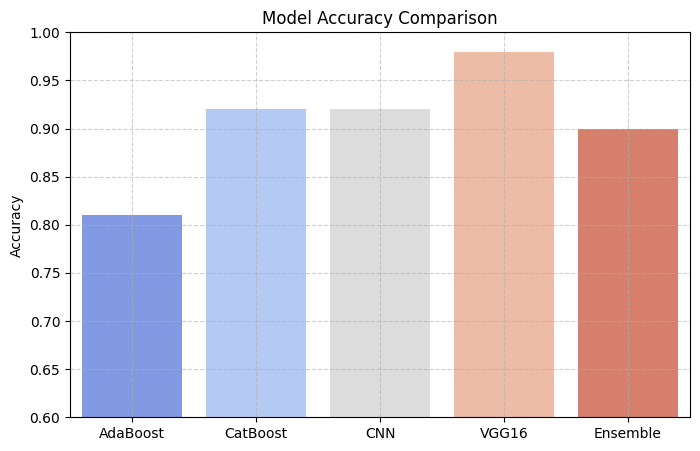

In [75]:
model_names = ['AdaBoost', 'CatBoost', 'CNN', 'VGG16', 'Ensemble']
accuracies = [0.81, 0.92, 0.92, 0.98, 0.90]

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracies, palette='coolwarm')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.6, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


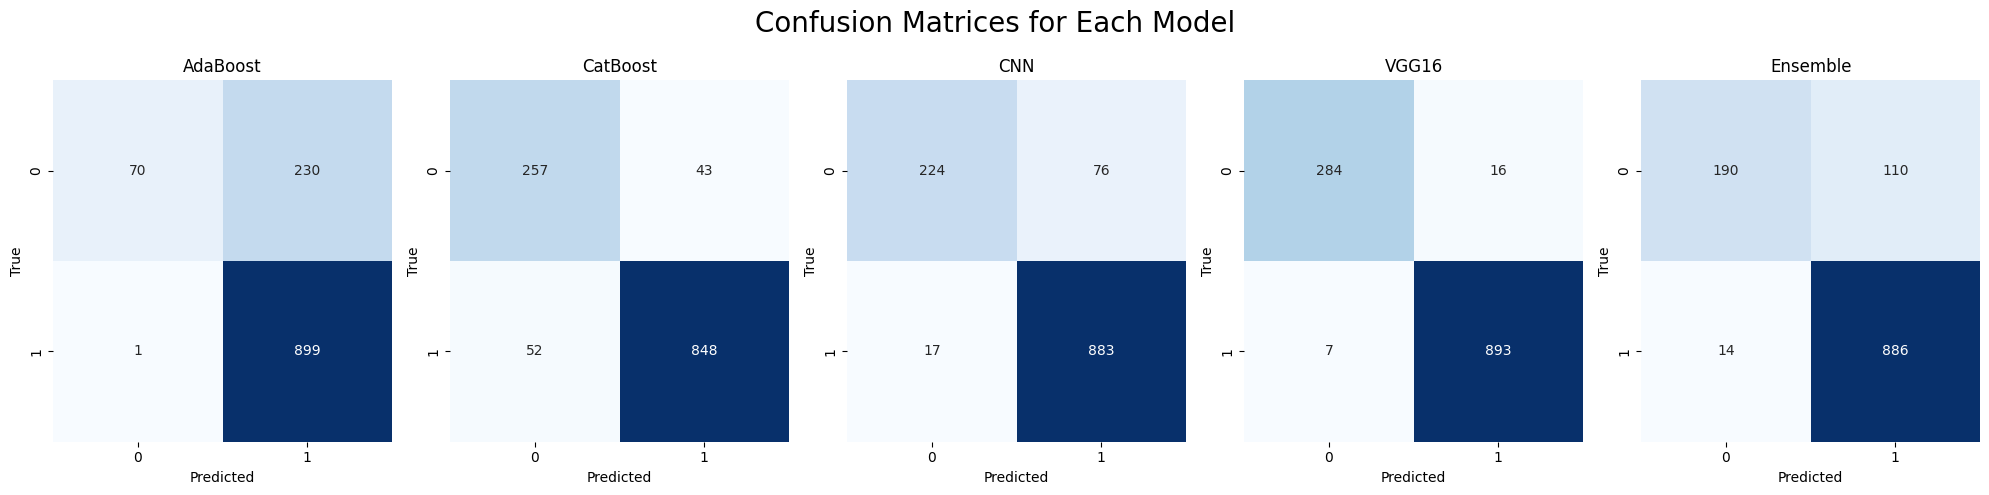

In [76]:
conf_matrices = {
    'AdaBoost': [[70, 230], [1, 899]],
    'CatBoost': [[257, 43], [52, 848]],
    'CNN': [[224, 76], [17, 883]],
    'VGG16': [[284, 16], [7, 893]],
    'Ensemble': [[190, 110], [14, 886]],
}

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,cbar=False)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.suptitle("Confusion Matrices for Each Model", fontsize=20)
plt.tight_layout()
plt.show()


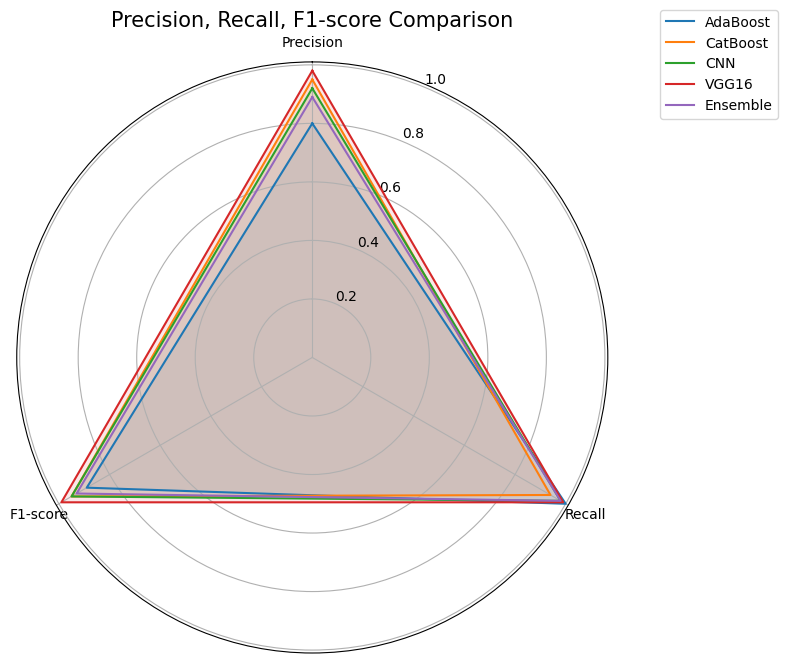

In [77]:

labels = ['Precision', 'Recall', 'F1-score']
models = {
    'AdaBoost': [0.80, 1.00, 0.89],
    'CatBoost': [0.95, 0.94, 0.95],
    'CNN': [0.92, 0.98, 0.95],
    'VGG16': [0.98, 0.99, 0.99],
    'Ensemble': [0.89, 0.98, 0.93]
}

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # complete loop

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

for name, scores in models.items():
    stats = scores + scores[:1]
    ax.plot(angles, stats, label=name)
    ax.fill(angles, stats, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Precision, Recall, F1-score Comparison", size=15)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


# Josia Mosses

In [78]:
data = {
    "Model": ["AdaBoost", "CatBoost", "CNN", "VGG16", "Ensemble"],
    "Accuracy": [0.81, 0.92, 0.92, 0.98, 0.90],
    "Precision": [0.80, 0.95, 0.92, 0.98, 0.89],
    "Recall": [1.00, 0.94, 0.92, 0.99, 0.98],
    "F1-score": [0.89, 0.95, 0.95, 0.99, 0.93]
}

df = pd.DataFrame(data)
df.set_index("Model", inplace=True)
print(df)


          Accuracy  Precision  Recall  F1-score
Model                                          
AdaBoost      0.81       0.80    1.00      0.89
CatBoost      0.92       0.95    0.94      0.95
CNN           0.92       0.92    0.92      0.95
VGG16         0.98       0.98    0.99      0.99
Ensemble      0.90       0.89    0.98      0.93


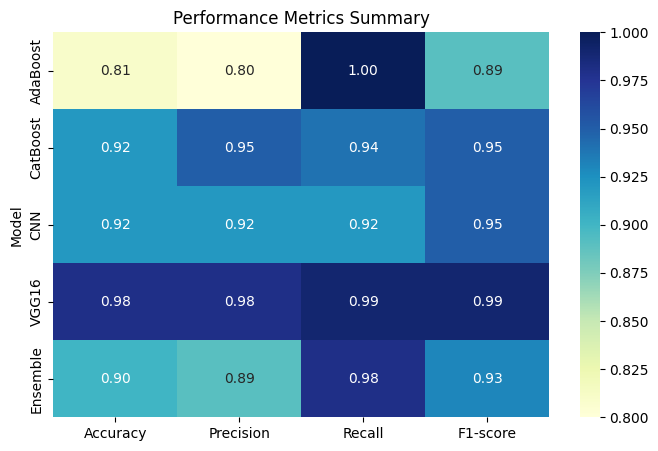

In [56]:
plt.figure(figsize=(8, 5))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Performance Metrics Summary")
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

# Dictionary to store probabilities for available models
available_probs = {}

# Get probabilities for available models
if 'cb_model' in globals() and cb_model is not None:
    probs_cb = get_model_probabilities(cb_model, X_test_flat, X_test_cnn, X_test_vgg, "CatBoost", IMAGE_SIZE)
    if probs_cb is not None and probs_cb.shape[0] > 0:
        available_probs["CatBoost"] = probs_cb[:, 1] # Get probability of the positive class
        print("Got probabilities for CatBoost")

if 'ab_model' in globals() and ab_model is not None:
    probs_ab = get_model_probabilities(ab_model, X_test_flat, X_test_cnn, X_test_vgg, "AdaBoost", IMAGE_SIZE)
    if probs_ab is not None and probs_ab.shape[0] > 0:
        available_probs["AdaBoost"] = probs_ab[:, 1] # Get probability of the positive class
        print("Got probabilities for AdaBoost")

if 'cnn_model' in globals() and cnn_model is not None:
    probs_cnn = get_model_probabilities(cnn_model, X_test_flat, X_test_cnn, X_test_vgg, "CNN", IMAGE_SIZE)
    if probs_cnn is not None and probs_cnn.shape[0] > 0:
        available_probs["CNN"] = probs_cnn[:, 1] # Get probability of the positive class
        print("Got probabilities for CNN")

if 'tl_model' in globals() and tl_model is not None:
    probs_tl = get_model_probabilities(tl_model, X_test_flat, X_test_cnn, X_test_vgg, "Transfer Learning (VGG16)", IMAGE_SIZE)
    if probs_tl is not None and probs_tl.shape[0] > 0:
        available_probs["Transfer Learning (VGG16)"] = probs_tl[:, 1] # Get probability of the positive class
        print("Got probabilities for Transfer Learning (VGG16)")

if 'resnet_model' in globals() and resnet_model is not None:
    probs_resnet = get_model_probabilities(resnet_model, X_test_flat, X_test_cnn, X_test_vgg, "ResNet50V2", IMAGE_SIZE)
    if probs_resnet is not None and probs_resnet.shape[0] > 0:
        available_probs["ResNet50V2"] = probs_resnet[:, 1] # Get probability of the positive class
        print("Got probabilities for ResNet50V2")

if 'efficientnet_model' in globals() and efficientnet_model is not None:
    probs_efficientnet = get_model_probabilities(efficientnet_model, X_test_flat, X_test_cnn, X_test_vgg, "EfficientNetB0", IMAGE_SIZE)
    if probs_efficientnet is not None and probs_efficientnet.shape[0] > 0:
        available_probs["EfficientNetB0"] = probs_efficientnet[:, 1] # Get probability of the positive class
        print("Got probabilities for EfficientNetB0")

# Plot ROC curves for available models
for model_name, y_pred_proba in available_probs.items():
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing') # Diagonal random guess line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Brain Tumor Detection Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()